In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#retrieve the dataset
import os
import zipfile
cwd = os.getcwd()
dataname = 'dataset_vehicles'
if os.path.exists(dataname):
    vehicle_path = dataname + '/dataset_vehicles/AC_VEI_AC_VEI_SUP_SR.shp'
else:
    !wget -nv -O dataset_vehicles.zip https://github.com/RiccardoBasilone/roadnets/raw/master/dataset_vehicles.zip -nc
    zip_filename = 'dataset_vehicles.zip'
    extract_dir = './dataset_vehicles'
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    vehicle_path = os.path.join(cwd,'dataset_vehicles/dataset_vehicles/AC_VEI_AC_VEI_SUP_SR.shp')

In [3]:
gdf = gpd.read_file(vehicle_path)

In [4]:
#initial cleaning 

gdf.drop(['AC_VEI_FON', 
          #'AC_VEI_LIV', 'AC_VEI_SED', 
          'CLASSREF'],axis = 1, inplace = True)
gdf.rename(columns={'SUBREGID':'ID', 'NOME': 'NAME', 'AC_VEI_ZON': 'TYPE'}, inplace = True)

# portions of road (e.g not intersections or parking lots) start with 01 in TYPE
# intersections, squares, and roundabouts start with 02 in TYPE

#gdf = gdf[~gdf['NAME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali
pattern1 = ('01','02')
gdf = gdf.loc[gdf.TYPE.str.startswith(pattern1)]

In [5]:
#we use openstreetmap crs, because it's a common projected (not geographic) CRS --> useful for calculating distances
OSM_crs = 3857
gdf.to_crs(epsg=OSM_crs, inplace = True)

In [6]:
#divides gdf into intersections and roads

def ints_and_roads(gdf):

    pattern2 = ('01')
    pattern3 = ('02') 
    pattern4 = ('0102') 
    roads = gdf.loc[(gdf.TYPE.str.startswith(pattern2)) #& ~ (gdf.TYPE.str.startswith(pattern4))
    ]
    ints = gdf.loc[(gdf.TYPE.str.startswith(pattern3)) #| (gdf.TYPE.str.startswith(pattern4))
    ]
    return ints, roads

In [7]:
#function creates geodataframe with all streets of gdf within distance dist (in meters) of street.
#street is a geodataframe, dist is a positive number, and gdf is the geodataframe dataset.

def within_dist(street, dist, gdf):

    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    gdf_distanced = gdf_distanced.dropna()
    gdf_distanced = gdf_distanced[~gdf_distanced.index.duplicated(keep='first')] #removes streets that are in more than one polygon's buffer
    gdf_distanced = gdf_distanced.iloc[:,:-1] #drops index_R column
    return gdf_distanced

In [8]:
#we define a variation of the within_dist function. This one keeps duplicate entries because they are useful for creating the graph later on.

def within_dist_dupes(street, dist, gdf):

    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    gdf_distanced = gdf_distanced.dropna()
    return gdf_distanced

In [9]:
#calculates width of all entries in gdf, and adds them to a width column. Assumes rectangular equivalent shape for polygons

def calc_widths(gdf):
    gdf['temp'] = 1 # create column of ones
    gdf['SemiPeri'] = -gdf.length/2 # i need it negative for the equation
    gdf['Area'] = gdf.area
    def calculate_roots(row):
        coefficients = row[['temp', 'SemiPeri', 'Area']].values
        roots = np.roots(coefficients).real
        return roots

    #gdf['roots'] = gdf.apply(calculate_roots, axis=1)
    gdf['roots'] = gdf[['temp', 'SemiPeri', 'Area']].apply(calculate_roots, axis=1)
    gdf[['length', 'width']] = pd.DataFrame(gdf['roots'].tolist(), index=gdf.index)
    gdf = gdf.drop([ 'Area', 'temp', 'SemiPeri', 'roots'], axis = 1)
    return gdf

In [10]:
#takes gdf, finds adjacent roads and dissolves them into one
def dissolver(gdf):

    #divide intersections and roads
        ints, roads = ints_and_roads(gdf)
    
    #gives adjacency for roads of gdf
        adj = within_dist_dupes(roads,0.1,roads)
        adj_ints = within_dist_dupes(ints,0.1,ints)
    
    #remove self connections and islands (speeds up execution significantly)
    #NB this works because index and index_right are the indices of two connected roads/ints
        adj = adj[adj.index_right != adj.index]
        adj_ints = adj_ints[adj_ints.index_right != adj_ints.index]

    #create network to find connected components
        edge_list = pd.DataFrame(zip(adj.index, adj.index_right), columns = ['from', 'to'])
        G = nx.from_pandas_edgelist(edge_list, 'from', 'to' , create_using=nx.MultiGraph())
        edge_list_ints = pd.DataFrame(zip(adj_ints.index, adj_ints.index_right), columns = ['from', 'to'])
        G_ints = nx.from_pandas_edgelist(edge_list_ints, 'from', 'to' , create_using=nx.MultiGraph())

    #store connected components in dictionary
        mylist = sorted(nx.connected_components(G), key = len, reverse = True)
        mydict = {i: val for i, val in enumerate(mylist)}
        mylist_ints = sorted(nx.connected_components(G_ints), key = len, reverse = True)
        mydict_ints = {-i-1: val for i, val in enumerate(mylist_ints)} #give negative keys to int chains, to distinguish from road chains
    
    #if index of the road/int is in dict, tag it with the key of the dict. if not, tag it with itself
        def get_key_or_index(idx, mydict):
            for key, indices in mydict.items():
                if idx in indices:
                    return key
            return idx

    #this is to suppress setting with copy warning
        pd.options.mode.chained_assignment = None
    #apply tagging function to all rows of the gdf
        roads['component'] = roads.index.map(lambda idx: get_key_or_index(idx, mydict))
        ints['component'] = ints.index.map(lambda idx: get_key_or_index(idx, mydict_ints))
        roads = roads.dissolve(by = 'component', as_index = False)
        ints = ints.dissolve(by = 'component', as_index = False)
        gdf = pd.concat([ints, roads])
        return gdf


In [11]:
def make_edges(gdf_tot):

    #prep
    #takes dataset with roads and intersections, creates edgelist of nodes with weights of edges
    ints, roads = ints_and_roads(gdf_tot)
    #we need indices from 0 --> reset
    ints.reset_index(inplace = True, drop = True)
    roads.reset_index(inplace = True, drop = True)


    #body
    stubs = within_dist_dupes(ints, 1, roads) #all stubs, i.e all roads connected to all nodes
    grouped = stubs.groupby('index_right') #one dataframe for each node
    edges = {} # will contain intersections of each node 
    edge_list = pd.DataFrame(columns = ['from','to','weight'])
    for node, group in grouped:
        stubs = stubs[stubs['index_right'] != node] #removing "self" from gdf that we will merge onto, to avoid self connections. also removes redundancies  
        edges[node] = pd.merge(group,stubs, on = 'ID', how = 'inner')
        edge_list_temp = pd.DataFrame({'from': edges[node].index_right_x, 'to': edges[node].index_right_y, 'weight': edges[node].width_x})
        edge_list = pd.concat([edge_list if not edge_list.empty 
                               else None,edge_list_temp])
    
    
    #exceptions    
    #adds self-edges to nodes that don't appear in to or from
    conc = pd.concat([edge_list['from'], edge_list['to']])
    all = set(range(0, len(ints))) #all possible nodes
    there = set(conc.unique()) #the nodes we actually have
    not_there = sorted(list(all-there)) #missing nodes (irregardless of why they're missing for the moment)
    df_self = pd.DataFrame({'from': not_there, 'to': not_there, 'weight': [1] * len(not_there)})
    edge_list = pd.concat([edge_list, df_self])
    return edge_list
    


In [12]:
def calc_pos(gdf, G):
    #takes dataset and network, calculates node positions and stores them in dict
    
    ints, _ = ints_and_roads(gdf)
    cent = ints.centroid
    coordinates = np.column_stack((cent.geometry.x, cent.geometry.y))
    positions = dict(zip(sorted(G.nodes), coordinates))
    return positions

In [13]:
def plot_clusters(positions, G):
    #takes network, plots clusters by color and edge width by color
    
    Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
    
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title("Road graph.\n Nodes are colored by cluster, and edges are colored by width")
    ax.axis("off")
    colorlist = [ 'r', 'g', 'b', 'y', 'orange']
    #plot each component one at a time
    
    for i in range(0, len(Gcc)):
        nx.draw_networkx_nodes(G, positions, nodelist = list(Gcc[i]), 
                               node_color = colorlist[i%5], ax=ax, 
                               node_size=0.8, alpha = 0.3)
    #now draw all edges using color map
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw_networkx_edges(G, positions, edge_color = weights, 
                           edge_cmap = plt.cm.inferno, 
                           edge_vmin = min(weights), edge_vmax = max(weights), width =0.3,
                           node_size = 0.9,
                           ax = ax)   
    #labels = nx.draw_networkx_labels(G, pos=positions, font_size = 6)
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    plt.savefig('graph clusters.png')
    plt.show()

# body

In [14]:
gdf = calc_widths(gdf)

In [15]:
gdf = gdf.loc[~gdf['NAME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali

In [16]:
gdf10 = gdf.copy()
gdf10.geometry = gdf10.geometry.buffer(0.5, join_style=1).buffer(-1, join_style=1).buffer(0.5, join_style = 1) #dulls corners

In [17]:
gdf10['SED_cpy'] = gdf10.AC_VEI_SED
gdf10['LIV_cpy'] = gdf10.AC_VEI_LIV #copies to dissolve columns
gdf10 = gdf10.groupby('SED_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = True)
gdf10 = gdf10.groupby('LIV_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = True)

C:\Users\rickb\anaconda3\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
C:\Users\rickb\AppData\Local\Temp\ipykernel_2864\3227306386.py:9: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf_distanced = gdf_distanced.dropna()
C:\Users\rickb\AppData\Local\Temp\ipykernel_2864\2288393397.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf10 = gdf10.groupby('SED_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = True)
C:

In [18]:
rows_with_nan = gdf10[gdf10.isna().any(axis=1)]

rows_with_nan

,component,geometry,NAME,ID,AC_VEI_LIV,AC_VEI_SED,TYPE,length,width,SED_cpy,LIV_cpy
13082,13666,None,STRADA SENZA NOME_279,AC_VEI_SR_5526,02,01,01,10.506032,0.427286,01,02


In [20]:
gdf10 = gdf10[gdf10.geometry.notna() & (gdf10.geom_type == 'Polygon')]

In [21]:
gdf10 = calc_widths(gdf10)
gdf10.reset_index(inplace = True, drop = True)

C:\Users\rickb\anaconda3\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\rickb\anaconda3\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\rickb\anaconda3\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [22]:
edges_10 = make_edges(gdf10)

G10 = nx.from_pandas_edgelist(edges_10, 'from', 'to', edge_attr=["weight"] , create_using=nx.MultiGraph())
Gcc = sorted(nx.connected_components(G10), key = len, reverse = True)

print("Number of components: ",len(Gcc),
      "\n largest: ",  len(Gcc[0]),
      "\n second largest: " , len(Gcc[1]),
      "\n third largest: " ,len(Gcc[2])
     )

Number of components:  83 
 largest:  7051 
 second largest:  44 
 third largest:  33


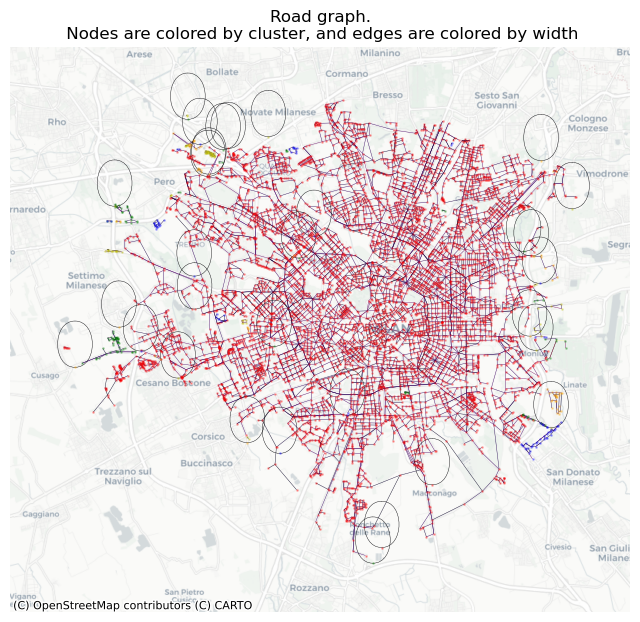

In [23]:
positions = calc_pos(gdf10, G10)
plot_clusters(positions, G10)